In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import io
import spacy
import re, string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

!pip install nltk
import nltk
nltk.download('stopwords')

df = pd.read_csv('dataPreprocessed.csv')
df

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,X,Title,Company,Location,Type,Salary,Contract_type,Job_Description,JobType,Industry,...,exp_normailzed,type_norm,Contract_type_norm,salary1,salary_min,salary_max,salary_avg,salary_norm,label,annual_pay
0,1,Construction Superintendent,"Curtis Construction Company, Inc.","Stoughton, MA 02072",Onsite,"$60,000 - $130,000",Full-time,Greater Boston based General Contractor is see...,Construction Management,Civil Engineering,...,0.5,-0.062757,1,"$60,000 - $130,000",60000.0,130000.0,95000.0,95000.0,Medium,95000.0
1,2,Regional Construction Manager,Chipotle Mexican Grill,"Atlanta, GA 30309",Onsite,"$89,000 - $161,000",Contract,Regional Construction Manager\nDescription\n\n...,Construction Management,Civil Engineering,...,0.1,-0.062757,0,"$89,000 - $161,000",89000.0,161000.0,125000.0,125000.0,High,125000.0
2,3,Construction Project Manager,Perfetto Contracting Co Inc,"Brooklyn, NY",Onsite,"$170,000 - $200,000",Full-time,Innovating infrastructure one project at a tim...,Construction Management,Civil Engineering,...,2.5,-0.062757,1,"$170,000 - $200,000",170000.0,200000.0,185000.0,185000.0,High,185000.0
3,5,Construction Manager,Chipotle Mexican Grill,"Denver, CO 80210",Onsite,"$89,000 - $161,000",Contract,Construction Manager\nDescription\n\nCULTIVATI...,Construction Management,Civil Engineering,...,0.1,-0.062757,0,"$89,000 - $161,000",89000.0,161000.0,125000.0,125000.0,High,125000.0
4,7,Project Manager - Construction (Hawaii),Burns & McDonnell,"Honolulu, HI",Onsite,"$220,000 - $428,000",Full-time,Description\nThe Project Manager is responsibl...,Construction Management,Civil Engineering,...,0.7,-0.062757,1,"$220,000 - $428,000",220000.0,428000.0,324000.0,324000.0,High,324000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5487,1206,TRAVEL AGENT,AppleOne,"San Juan, PR 00920",Onsite,$11 - $14,Contract,Plan and sell transportation and accommodation...,Travel Agent,Tourism,...,0.1,-0.062757,0,$11 - $14,11.0,14.0,12.5,26000.0,Low,26000.0
5488,1207,LOTTERY-Accounts Payable Travel Specialist (Ac...,Texas Comptroller of Public Accounts,"Austin, TX 78701",Onsite,"$2,748 - $3,750",Contract,LOTTERY-Accounts Payable Travel Specialist (Ac...,Travel Agent,Tourism,...,NaN,-0.062757,0,"$2,748 - $3,750",2748.0,3750.0,3249.0,3249.0,Low,3249.0
5489,1208,Reservation Specialist/Beach Services,Scupper's Watersports,"Saint Pete Beach, FL",Onsite,$13 - $15,Contract,Probably the best job on the island. We are a ...,Travel Agent,Tourism,...,0.1,-0.062757,0,$13 - $15,13.0,15.0,14.0,29120.0,Low,29120.0
5490,1213,Travel Coordinator,Renew Digital LLC,United States,Onsite,"$40,000 - $45,000",Full-time,TRAVEL COORDINATOR\nTHE OPPORTUNITY:\nBecause ...,Travel Agent,Tourism,...,0.1,-0.062757,1,"$40,000 - $45,000",40000.0,45000.0,42500.0,42500.0,Low,42500.0


In [44]:
class_df = df.groupby('label').count()
class_df.style.background_gradient(cmap='PiYG')

,X,Title,Company,Location,Type,Salary,Contract_type,Job_Description,JobType,Industry,experience,exp_normailzed,type_norm,Contract_type_norm,salary1,salary_min,salary_max,salary_avg,salary_norm,annual_pay
label,,,,,,,,,,,,,,,,,,,,
High,1478,1478,1478,1478,1478,1478,1478,1478,1478,1478,946,946,1478,1478,1478,1478,1478,1478,1478,1478
Low,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,802,802,1652,1652,1652,1652,1652,1652,1652,1652
Medium,2362,2362,2348,2362,2362,2362,2362,2362,2361,2361,1528,1528,2362,2362,2362,2362,2362,2362,2362,2362


In [46]:
stopword = stopwords.words('english')

def clean(text):
    text = text.lower() # lower case
    text = re.sub(r'https?://\S+|www\.\S+', " ", text)#URL
    text = re.sub(r'@\w+',' ',text) # mentions
    text = re.sub(r'#\w+', ' ', text) #hashtags
    text= re.sub(r'[^\w\s]',' ',text) #punctuations
    text= re.sub(r'\d+', ' ', text) #digits
    text = re.sub('\[.*?\]',' ', text) #any punctuations left
    text = re.sub("[^a-z0-9]"," ", text)# any others charcters other than numbers and letters
    text = text.split() #stopwords
    text = " ".join([word for word in text if not word in stopword])
    return text

df['Job_Description'] = df['Job_Description'].astype(str).apply(lambda x: clean(x))
df.head(10)

,X,Title,Company,Location,Type,Salary,Contract_type,Job_Description,JobType,Industry,...,exp_normailzed,type_norm,Contract_type_norm,salary1,salary_min,salary_max,salary_avg,salary_norm,label,annual_pay
0,1,Construction Superintendent,"Curtis Construction Company, Inc.","Stoughton, MA 02072",Onsite,"$60,000 - $130,000",Full-time,greater boston based general contractor seekin...,Construction Management,Civil Engineering,...,0.5,-0.062757,1,"$60,000 - $130,000",60000.0,130000.0,95000.0,95000.0,Medium,95000.0
1,2,Regional Construction Manager,Chipotle Mexican Grill,"Atlanta, GA 30309",Onsite,"$89,000 - $161,000",Contract,regional construction manager description cult...,Construction Management,Civil Engineering,...,0.1,-0.062757,0,"$89,000 - $161,000",89000.0,161000.0,125000.0,125000.0,High,125000.0
2,3,Construction Project Manager,Perfetto Contracting Co Inc,"Brooklyn, NY",Onsite,"$170,000 - $200,000",Full-time,innovating infrastructure one project time per...,Construction Management,Civil Engineering,...,2.5,-0.062757,1,"$170,000 - $200,000",170000.0,200000.0,185000.0,185000.0,High,185000.0
3,5,Construction Manager,Chipotle Mexican Grill,"Denver, CO 80210",Onsite,"$89,000 - $161,000",Contract,construction manager description cultivating b...,Construction Management,Civil Engineering,...,0.1,-0.062757,0,"$89,000 - $161,000",89000.0,161000.0,125000.0,125000.0,High,125000.0
4,7,Project Manager - Construction (Hawaii),Burns & McDonnell,"Honolulu, HI",Onsite,"$220,000 - $428,000",Full-time,description project manager responsible managi...,Construction Management,Civil Engineering,...,0.7,-0.062757,1,"$220,000 - $428,000",220000.0,428000.0,324000.0,324000.0,High,324000.0
5,8,Construction Manager,Black & Veatch Corporation,"San Diego, CA",Onsite,"$178,000 - $220,000",Full-time,together company future shared success employe...,Construction Management,Civil Engineering,...,10.0,-0.062757,1,"$178,000 - $220,000",178000.0,220000.0,199000.0,199000.0,High,199000.0
6,12,Construction Sales - Project Management,The Neill Company,"Orange Park, FL 32073",Onsite,"$65,000 - $135,000",Contract,neill company premier commercial residential c...,Construction Management,Civil Engineering,...,1.5,-0.062757,0,"$65,000 - $135,000",65000.0,135000.0,100000.0,100000.0,Medium,100000.0
7,16,Residential Construction Project Manager,RTG,"San Jose, CA",Onsite,"$125,000 - $150,000",Full-time,well established growing construction company ...,Construction Management,Civil Engineering,...,NaN,-0.062757,1,"$125,000 - $150,000",125000.0,150000.0,137500.0,137500.0,High,137500.0
8,18,Experienced Construction Management Specialist,BOEING,"Springfield, VA",Onsite,"$93,500 - $126,500",Contract,boeing innovate collaborate make world better ...,Construction Management,Civil Engineering,...,0.1,-0.062757,0,"$93,500 - $126,500",93500.0,126500.0,110000.0,110000.0,Medium,110000.0
9,19,"Residential Property/Construction Manager, Gen...",Soar Real Estate,"Fort Lee, NJ",Onsite,"$140,000 - $190,000",Full-time,residential property manager general manager c...,Construction Management,Civil Engineering,...,0.3,-0.062757,1,"$140,000 - $190,000",140000.0,190000.0,165000.0,165000.0,High,165000.0


In [47]:
# This model is a small and fast model for English language text processing, and it includes features such as part-of-speech tagging, named entity recognition, and dependency parsing
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    #For converting paragrapg to sentence
    # spacy. is object oriented
    # Dr. Ram is eating.He is not available.
    # -> [Dr. Ram is eating. He is not available]
    doc = nlp(text)

    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

df['preprocessed_txt'] = df['Job_Description'].apply(preprocess) 

In [63]:
x = df['preprocessed_txt']
y = df['label']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022, #keep using the same sample for training or testing
    stratify=y #balance category used in training the model
    )
x_train, val_X, y_train, val_Y = train_test_split(
    x, y, 
    test_size=0.1, # 10% samples will go to validation dataset
    random_state=2022, 
    stratify=y)
x_train.shape



(4942,)

### ***N-gram (n=5)*** 

In [64]:
# create CountVectorizer object
vectorizer = CountVectorizer(ngram_range= (1,5)).fit(x_train)
train_X_cv = vectorizer.fit_transform(x_train)
test_X_cv = vectorizer.transform(x_test)
val_X_cv = vectorizer.transform(val_X)

tfidf_transformer = TfidfTransformer()
train_X_tfidf = tfidf_transformer.fit_transform(train_X_cv)
test_X_tfidf = tfidf_transformer.transform(test_X_cv)
val_X_tfidf = tfidf_transformer.fit_transform(val_X_cv)

### ***Logistic Regression N-gram (n=5) C=1*** 





LR Validation Accuracy ->  81.81818181818183
LR Test Accuracy ->  90.8098271155596
              precision    recall  f1-score   support

        High       0.96      0.84      0.89       296
         Low       0.93      0.92      0.92       330
      Medium       0.87      0.95      0.91       473

    accuracy                           0.91      1099
   macro avg       0.92      0.90      0.91      1099
weighted avg       0.91      0.91      0.91      1099

              precision    recall  f1-score   support

        High       0.92      0.66      0.77       148
         Low       0.85      0.84      0.85       165
      Medium       0.76      0.90      0.82       237

    accuracy                           0.82       550
   macro avg       0.84      0.80      0.81       550
weighted avg       0.83      0.82      0.82       550



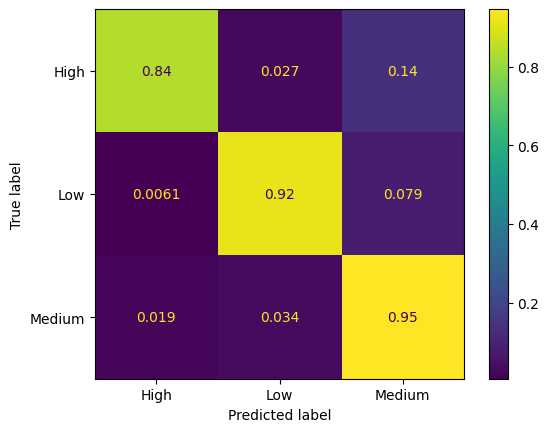

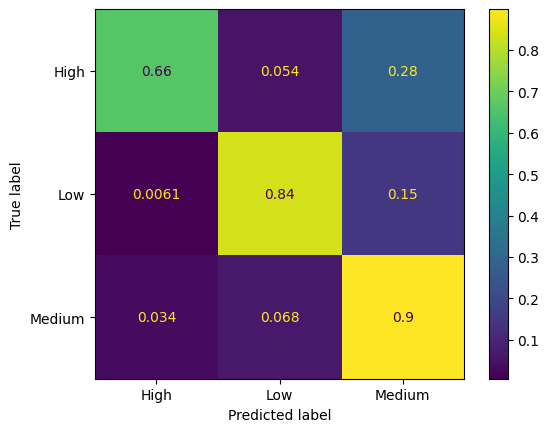

In [65]:
from sklearn.metrics import accuracy_score

lr = LogisticRegression(penalty="l2",multi_class = "multinomial",solver = "saga", C=1, max_iter=5000)
lr.fit(train_X_tfidf,y_train)
lr_pred = lr.predict(test_X_tfidf)
lrv1_pred = lr.predict(val_X_tfidf)

print("LR Validation Accuracy -> ",accuracy_score(lrv1_pred, val_Y)*100)
print("LR Test Accuracy -> ",accuracy_score(lr_pred, y_test)*100)

print(classification_report(y_test, lr_pred))
print(classification_report(val_Y, lrv1_pred))

lr_cm = confusion_matrix(y_test, lr_pred, normalize="true")
lrv_cm = confusion_matrix(val_Y, lrv1_pred, normalize="true")


disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=lr.classes_)
disp.plot()
plt.show()

disp2 = ConfusionMatrixDisplay(confusion_matrix=lrv_cm, display_labels=lr.classes_)
disp2.plot()
plt.show()

### ***Logistic Regression N-gram (n=5) C=10*** 


LR Validation Accuracy ->  87.45454545454545
LR Test Accuracy ->  93.63057324840764
              precision    recall  f1-score   support

        High       0.97      0.90      0.93       296
         Low       0.94      0.95      0.94       330
      Medium       0.92      0.95      0.93       473

    accuracy                           0.94      1099
   macro avg       0.94      0.93      0.94      1099
weighted avg       0.94      0.94      0.94      1099

              precision    recall  f1-score   support

        High       0.92      0.82      0.87       148
         Low       0.89      0.89      0.89       165
      Medium       0.84      0.90      0.87       237

    accuracy                           0.87       550
   macro avg       0.88      0.87      0.88       550
weighted avg       0.88      0.87      0.87       550



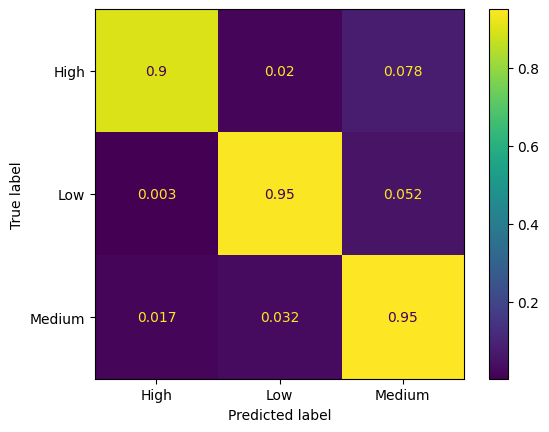

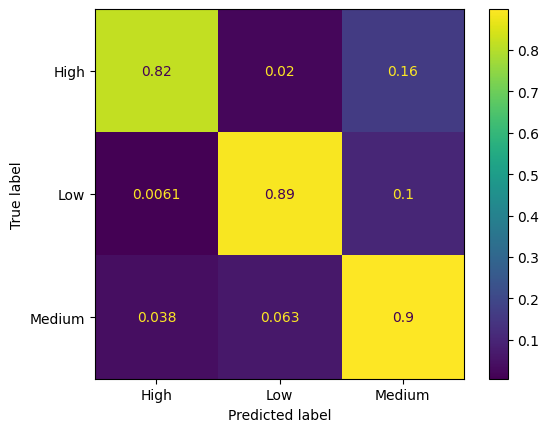

In [66]:
lr = LogisticRegression(penalty="l2",multi_class = "multinomial",solver = "saga", C=10, max_iter=5000)
lr.fit(train_X_tfidf,y_train)
lr_pred = lr.predict(test_X_tfidf)
lrv1_pred = lr.predict(val_X_tfidf)

print("LR Validation Accuracy -> ",accuracy_score(lrv1_pred, val_Y)*100)
print("LR Test Accuracy -> ",accuracy_score(lr_pred, y_test)*100)

print(classification_report(y_test, lr_pred))
print(classification_report(val_Y, lrv1_pred))

lr_cm = confusion_matrix(y_test, lr_pred, normalize="true")
lrv_cm = confusion_matrix(val_Y, lrv1_pred, normalize="true")


disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=lr.classes_)
disp.plot()
plt.show()

disp2 = ConfusionMatrixDisplay(confusion_matrix=lrv_cm, display_labels=lr.classes_)
disp2.plot()
plt.show()

### ***Multinomial Naive Bayes N-gram (n=5) alpha=0.1 and fit_prior=True*** 


NB Validation Accuracy ->  82.0
NB Test Accuracy ->  89.80891719745223
NB Test -> 
              precision    recall  f1-score   support

        High       0.95      0.81      0.88       296
         Low       0.95      0.89      0.92       330
      Medium       0.85      0.96      0.90       473

    accuracy                           0.90      1099
   macro avg       0.91      0.89      0.90      1099
weighted avg       0.90      0.90      0.90      1099

NB Validation -> 
              precision    recall  f1-score   support

        High       0.92      0.64      0.76       148
         Low       0.92      0.81      0.86       165
      Medium       0.74      0.94      0.83       237

    accuracy                           0.82       550
   macro avg       0.86      0.80      0.81       550
weighted avg       0.84      0.82      0.82       550



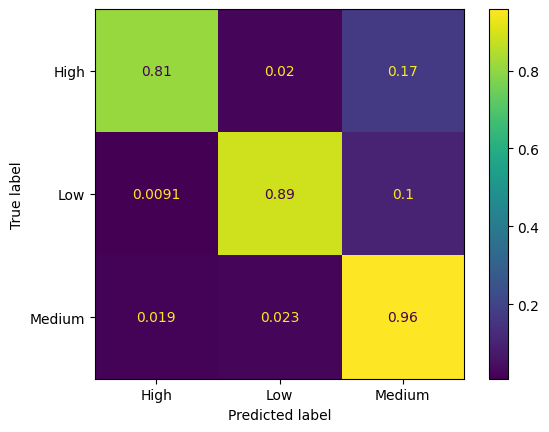

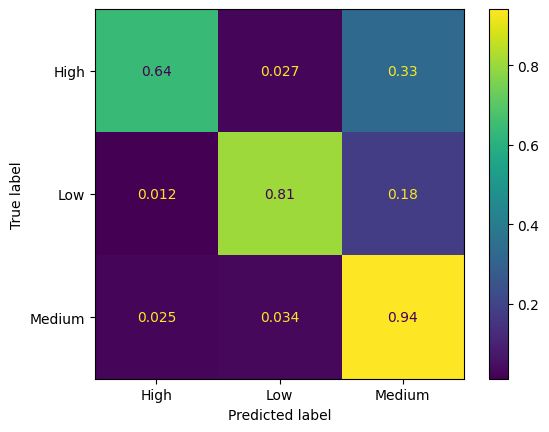

In [67]:
nb = MultinomialNB(alpha=0.1, fit_prior=True)
nb.fit(train_X_tfidf,y_train)
nb_pred = nb.predict(test_X_tfidf)
nbv1_pred = nb.predict(val_X_tfidf)

print("NB Validation Accuracy -> ",accuracy_score(nbv1_pred, val_Y)*100)
print("NB Test Accuracy -> ",accuracy_score(nb_pred, y_test)*100)

print("NB Test -> ")
print(classification_report(y_test, nb_pred))
print("NB Validation -> ")
print(classification_report(val_Y, nbv1_pred))

nb_cm = confusion_matrix(y_test, nb_pred, normalize="true")
nbv_cm = confusion_matrix(val_Y, nbv1_pred, normalize="true")

display = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=nb.classes_)
display.plot()
plt.show()

display = ConfusionMatrixDisplay(confusion_matrix=nbv_cm, display_labels=nb.classes_)
display.plot()
plt.show()


### ***Multinomial Naive Bayes N-gram (n=5) alpha=1**




NB Validation Accuracy ->  87.45454545454545
NB Test Accuracy ->  74.43130118289353
NB Test -> 
              precision    recall  f1-score   support

        High       0.96      0.44      0.61       296
         Low       0.95      0.68      0.79       330
      Medium       0.64      0.98      0.77       473

    accuracy                           0.74      1099
   macro avg       0.85      0.70      0.72      1099
weighted avg       0.82      0.74      0.73      1099

NB Validation -> 
              precision    recall  f1-score   support

        High       0.92      0.82      0.87       148
         Low       0.89      0.89      0.89       165
      Medium       0.84      0.90      0.87       237

    accuracy                           0.87       550
   macro avg       0.88      0.87      0.88       550
weighted avg       0.88      0.87      0.87       550



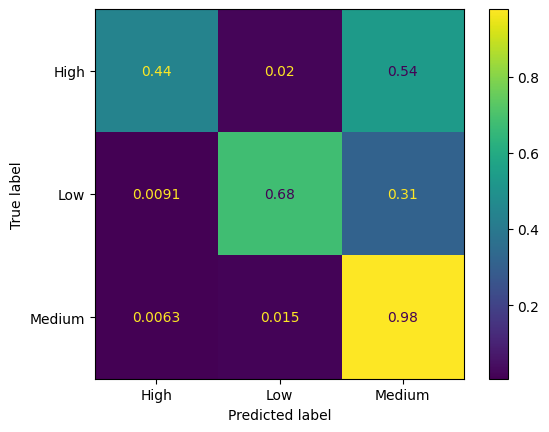

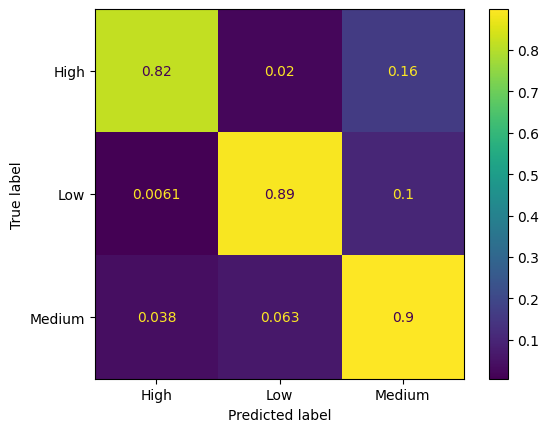

In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nb = MultinomialNB(alpha=1, fit_prior=True)
nb.fit(train_X_tfidf,y_train)
nb_pred = nb.predict(test_X_tfidf)
nbv1_pred = lr.predict(val_X_tfidf)

print("NB Validation Accuracy -> ",accuracy_score(nbv1_pred, val_Y)*100)
print("NB Test Accuracy -> ",accuracy_score(nb_pred, y_test)*100)

print("NB Test -> ")
print(classification_report(y_test, nb_pred))
print("NB Validation -> ")
print(classification_report(val_Y, nbv1_pred))

nb_cm = confusion_matrix(y_test, nb_pred, normalize="true")
nbv_cm = confusion_matrix(val_Y, nbv1_pred, normalize="true")

display = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=nb.classes_)
display.plot()
plt.show()

display = ConfusionMatrixDisplay(confusion_matrix=nbv_cm, display_labels=nb.classes_)
display.plot()
plt.show()

### **Multinomial Naive Bayes N-gram (n=5) alpha=0.5**

NB Validation Accuracy ->  71.81818181818181
NB Test Accuracy ->  82.7115559599636
NB Test -> 
              precision    recall  f1-score   support

        High       0.96      0.64      0.76       296
         Low       0.95      0.79      0.87       330
      Medium       0.73      0.97      0.83       473

    accuracy                           0.83      1099
   macro avg       0.88      0.80      0.82      1099
weighted avg       0.86      0.83      0.82      1099

NB Validation -> 
              precision    recall  f1-score   support

        High       0.94      0.41      0.57       148
         Low       0.92      0.66      0.77       165
      Medium       0.61      0.95      0.75       237

    accuracy                           0.72       550
   macro avg       0.83      0.67      0.69       550
weighted avg       0.79      0.72      0.71       550



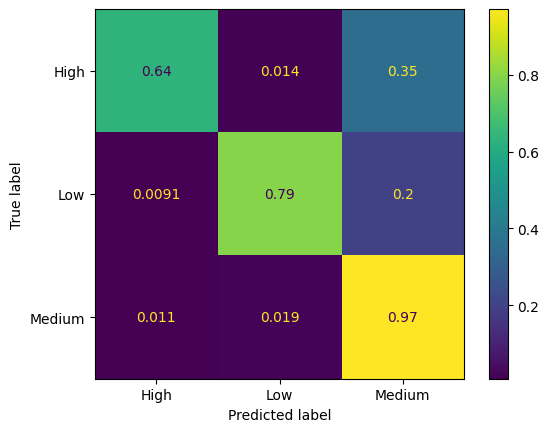

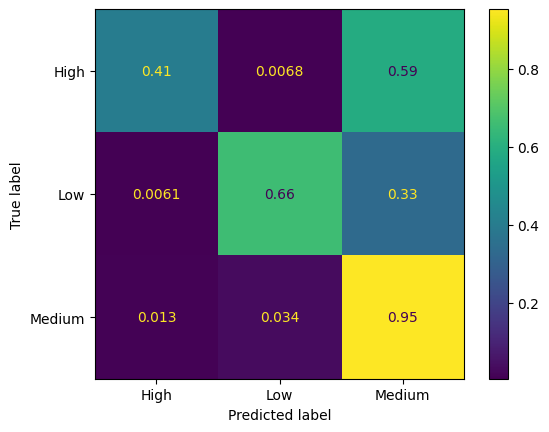

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nb = MultinomialNB(alpha=0.5, fit_prior=True)
nb.fit(train_X_tfidf,y_train)
nb_pred = nb.predict(test_X_tfidf)
nbv1_pred = nb.predict(val_X_tfidf)

print("NB Validation Accuracy -> ",accuracy_score(nbv1_pred, val_Y)*100)
print("NB Test Accuracy -> ",accuracy_score(nb_pred, y_test)*100)

print("NB Test -> ")
print(classification_report(y_test, nb_pred))
print("NB Validation -> ")
print(classification_report(val_Y, nbv1_pred))

nb_cm = confusion_matrix(y_test, nb_pred, normalize="true")
nbv_cm = confusion_matrix(val_Y, nbv1_pred, normalize="true")

display = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=nb.classes_)
display.plot()
plt.show()

display = ConfusionMatrixDisplay(confusion_matrix=nbv_cm, display_labels=nb.classes_)
display.plot()
plt.show()

### **Tri-grams (n=3)**

In [70]:
# create CountVectorizer object
vectorizer_3 = CountVectorizer(ngram_range= (1,3)).fit(x_train)
train_X_cv_3 = vectorizer.fit_transform(x_train)
test_X_cv_3 = vectorizer.transform(x_test)
val_X_cv_3 = vectorizer.transform(val_X)

# create TfidfTransformer object
tfidf_transformer = TfidfTransformer()
train_X_tfidf_3 = tfidf_transformer.fit_transform(train_X_cv_3)
test_X_tfidf_3 = tfidf_transformer.transform(test_X_cv_3)
val_X_tfidf_3 = tfidf_transformer.fit_transform(val_X_cv_3)

### **Multinomial Naive Bayes Tri-gram (n=3) alpha=1**




              precision    recall  f1-score   support

        High       0.96      0.55      0.70       296
         Low       0.94      0.73      0.82       330
      Medium       0.68      0.97      0.80       473

    accuracy                           0.79      1099
   macro avg       0.86      0.75      0.78      1099
weighted avg       0.84      0.79      0.78      1099

              precision    recall  f1-score   support

        High       0.94      0.34      0.50       148
         Low       0.91      0.61      0.73       165
      Medium       0.59      0.96      0.73       237

    accuracy                           0.69       550
   macro avg       0.81      0.64      0.66       550
weighted avg       0.78      0.69      0.67       550

NB for n=3 Validation Accuracy ->  68.9090909090909
NB for n=3 Test Accuracy ->  78.6169244767971


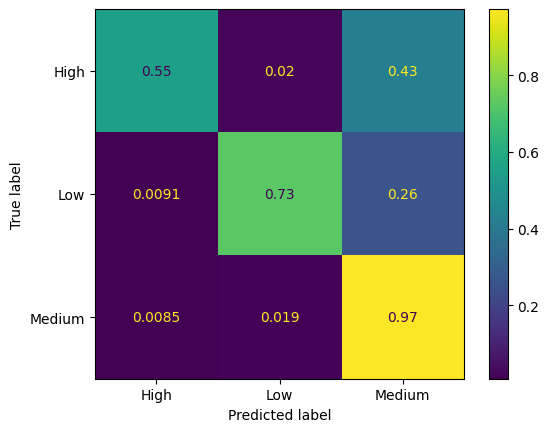

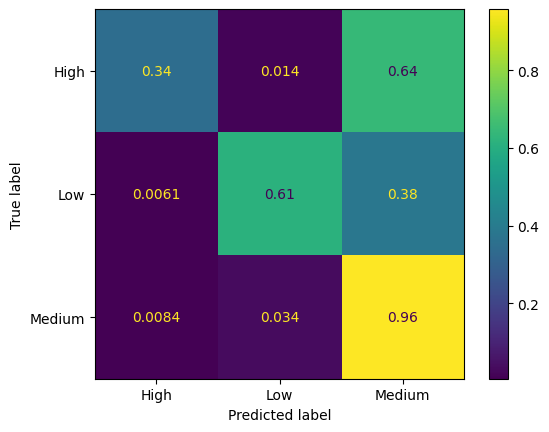

In [71]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Without alpha
nb_3 = MultinomialNB(alpha =1, fit_prior=False)
nb_3.fit(train_X_tfidf_3,y_train)
nb_pred_3 = nb_3.predict(test_X_tfidf_3)
nbv1_pred_3 = nb_3.predict(val_X_tfidf)

print(classification_report(y_test, nb_pred_3))
print(classification_report(val_Y, nbv1_pred_3))

print("NB for n=3 Validation Accuracy -> ",accuracy_score(nbv1_pred_3, val_Y)*100)
print("NB for n=3 Test Accuracy -> ",accuracy_score(nb_pred_3, y_test)*100)

nb_cm_3 = confusion_matrix(y_test, nb_pred_3, normalize="true")
nbv_cm_3 = confusion_matrix(val_Y, nbv1_pred_3, normalize="true")

display_3 = ConfusionMatrixDisplay(confusion_matrix=nb_cm_3, display_labels=nb_3.classes_)
display_3.plot()
plt.show()

displayv_3 = ConfusionMatrixDisplay(confusion_matrix=nbv_cm_3, display_labels=nb_3.classes_)
displayv_3.plot()
plt.show()

### **Multinomial Naive Bayes Tri-gram (n=3) alpha=0.1**


              precision    recall  f1-score   support

        High       0.95      0.81      0.88       296
         Low       0.95      0.89      0.92       330
      Medium       0.85      0.96      0.90       473

    accuracy                           0.90      1099
   macro avg       0.91      0.89      0.90      1099
weighted avg       0.90      0.90      0.90      1099

              precision    recall  f1-score   support

        High       0.92      0.82      0.87       148
         Low       0.89      0.89      0.89       165
      Medium       0.84      0.90      0.87       237

    accuracy                           0.87       550
   macro avg       0.88      0.87      0.88       550
weighted avg       0.88      0.87      0.87       550

NB for n=3 Validation Accuracy ->  87.45454545454545
NB for n=3 Test Accuracy ->  89.80891719745223


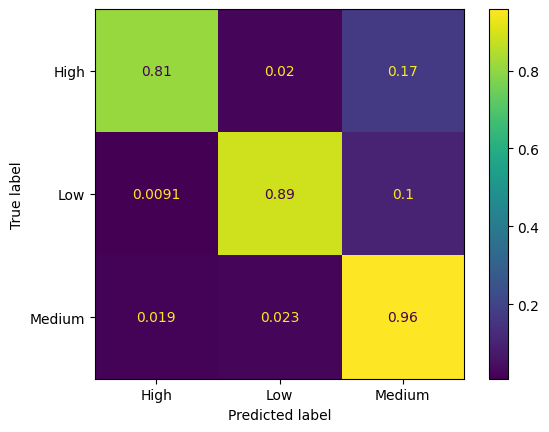

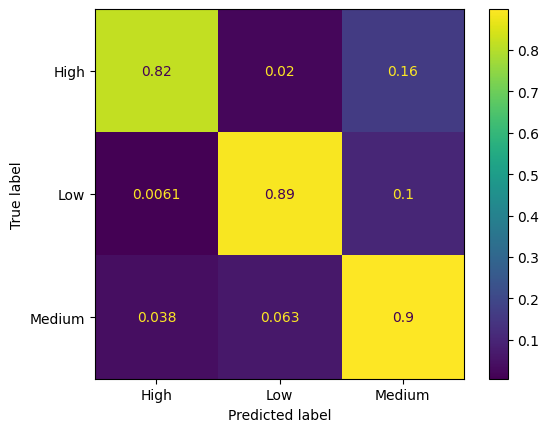

In [75]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Without alpha
nb_3 = MultinomialNB(alpha =0.1, fit_prior=True)
nb_3.fit(train_X_tfidf_3,y_train)
nb_pred_3 = nb_3.predict(test_X_tfidf_3)
nbv1_pred_3 = lr.predict(val_X_tfidf)

print(classification_report(y_test, nb_pred_3))
print(classification_report(val_Y, nbv1_pred_3))

print("NB for n=3 Validation Accuracy -> ",accuracy_score(nbv1_pred_3, val_Y)*100)
print("NB for n=3 Test Accuracy -> ",accuracy_score(nb_pred_3, y_test)*100)

nb_cm_3 = confusion_matrix(y_test, nb_pred_3, normalize="true")
nbv_cm_3 = confusion_matrix(val_Y, nbv1_pred_3, normalize="true")

display_3 = ConfusionMatrixDisplay(confusion_matrix=nb_cm_3, display_labels=nb_3.classes_)
display_3.plot()
plt.show()

displayv_3 = ConfusionMatrixDisplay(confusion_matrix=nbv_cm_3, display_labels=nb_3.classes_)
displayv_3.plot()
plt.show()

              precision    recall  f1-score   support

        High       0.95      0.82      0.88       296
         Low       0.94      0.90      0.92       330
      Medium       0.86      0.96      0.91       473

    accuracy                           0.91      1099
   macro avg       0.92      0.90      0.90      1099
weighted avg       0.91      0.91      0.91      1099

              precision    recall  f1-score   support

        High       0.92      0.82      0.87       148
         Low       0.89      0.89      0.89       165
      Medium       0.84      0.90      0.87       237

    accuracy                           0.87       550
   macro avg       0.88      0.87      0.88       550
weighted avg       0.88      0.87      0.87       550

NB for n=3 Validation Accuracy ->  87.45454545454545
NB for n=3 Test Accuracy ->  90.5368516833485


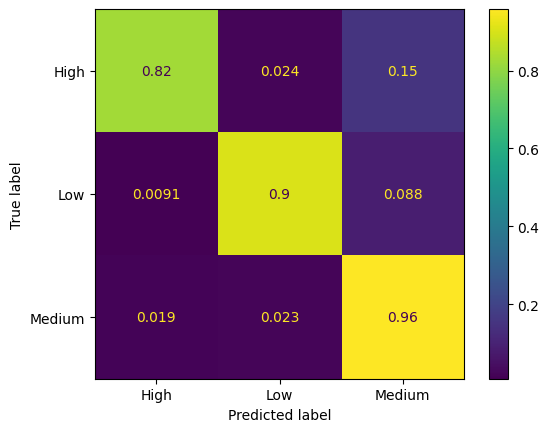

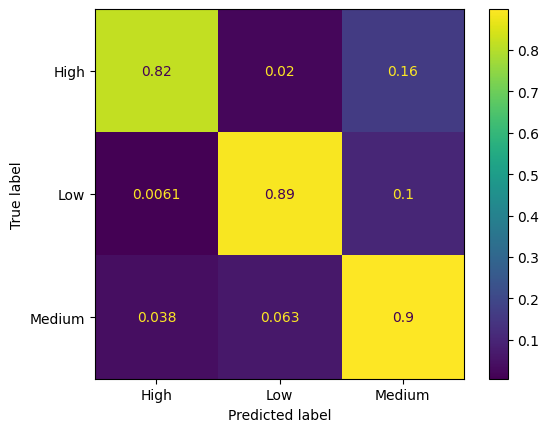

In [76]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Without alpha
nb_3 = MultinomialNB(alpha =0.1, fit_prior=False)
nb_3.fit(train_X_tfidf_3,y_train)
nb_pred_3 = nb_3.predict(test_X_tfidf_3)
nbv1_pred_3 = lr.predict(val_X_tfidf)

print(classification_report(y_test, nb_pred_3))
print(classification_report(val_Y, nbv1_pred_3))

print("NB for n=3 Validation Accuracy -> ",accuracy_score(nbv1_pred_3, val_Y)*100)
print("NB for n=3 Test Accuracy -> ",accuracy_score(nb_pred_3, y_test)*100)

nb_cm_3 = confusion_matrix(y_test, nb_pred_3, normalize="true")
nbv_cm_3 = confusion_matrix(val_Y, nbv1_pred_3, normalize="true")

display_3 = ConfusionMatrixDisplay(confusion_matrix=nb_cm_3, display_labels=nb_3.classes_)
display_3.plot()
plt.show()

displayv_3 = ConfusionMatrixDisplay(confusion_matrix=nbv_cm_3, display_labels=nb_3.classes_)
displayv_3.plot()
plt.show()

### **Multinomial Naive Bayes Tri-gram (n=3) alpha=0.5**


              precision    recall  f1-score   support

        High       0.96      0.69      0.80       296
         Low       0.95      0.82      0.88       330
      Medium       0.76      0.97      0.85       473

    accuracy                           0.85      1099
   macro avg       0.89      0.83      0.84      1099
weighted avg       0.87      0.85      0.85      1099

              precision    recall  f1-score   support

        High       0.93      0.48      0.63       148
         Low       0.93      0.68      0.78       165
      Medium       0.64      0.95      0.76       237

    accuracy                           0.74       550
   macro avg       0.83      0.70      0.73       550
weighted avg       0.80      0.74      0.73       550

NB for n=3 Validation Accuracy ->  74.18181818181819
NB for n=3 Test Accuracy ->  84.80436760691538


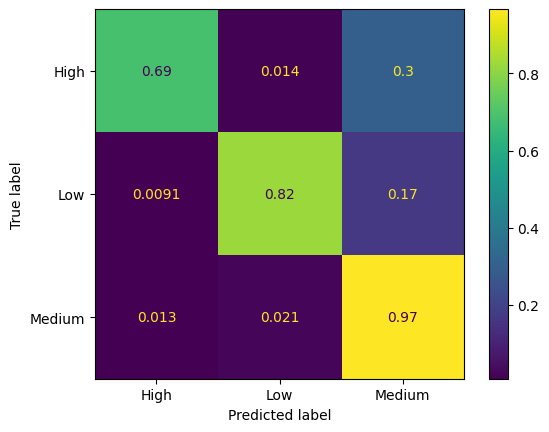

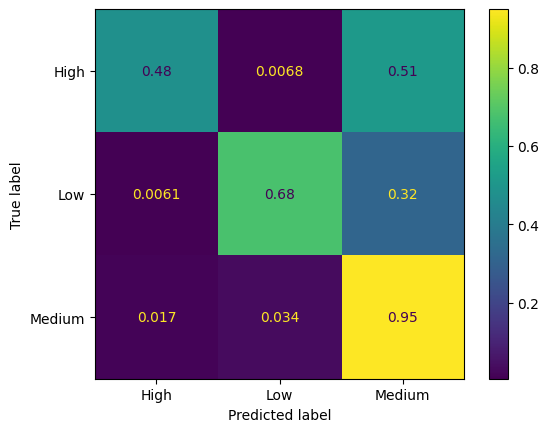

In [74]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Without alpha
nb_3 = MultinomialNB(alpha =0.5, fit_prior=False)
nb_3.fit(train_X_tfidf_3,y_train)
nb_pred_3 = nb_3.predict(test_X_tfidf_3)
nbv1_pred_3 = nb_3.predict(val_X_tfidf)

print(classification_report(y_test, nb_pred_3))
print(classification_report(val_Y, nbv1_pred_3))

print("NB for n=3 Validation Accuracy -> ",accuracy_score(nbv1_pred_3, val_Y)*100)
print("NB for n=3 Test Accuracy -> ",accuracy_score(nb_pred_3, y_test)*100)

nb_cm_3 = confusion_matrix(y_test, nb_pred_3, normalize="true")
nbv_cm_3 = confusion_matrix(val_Y, nbv1_pred_3, normalize="true")

display_3 = ConfusionMatrixDisplay(confusion_matrix=nb_cm_3, display_labels=nb_3.classes_)
display_3.plot()
plt.show()

displayv_3 = ConfusionMatrixDisplay(confusion_matrix=nbv_cm_3, display_labels=nb_3.classes_)
displayv_3.plot()
plt.show()